### Step 1 Import libraries and the dataset

Here we use the Online Retail Dataset from Kaggle. Online Retail is a transactional dataset which contains data all the transactions happened between 2010 and 2011 for a UK based and registeres non-store online retail.

In [243]:
import numpy as np
import pandas as pd


from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans


from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from sklearn.decomposition import PCA


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

        
data = pd.read_csv(r"C:\Users\soas\Downloads\archive\transactions_train.csv")

In [244]:
display(data.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 6.3 GB


None

In [245]:
f = pd.read_csv(r"C:\Users\soas\Downloads\archive\transactions_train.csv",chunksize= 1000000)
chunk_list = []                
for chunk in f:     
    # Once the data filtering is done, append the filtered chunk to list
    chunk_list.append(chunk)

In [246]:
chunk_list

[             t_dat                                        customer_id  \
 0       2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
 1       2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
 2       2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
 3       2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
 4       2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
 ...            ...                                                ...   
 999995  2018-10-11  4615f5dbbdfc0cc1af245bc0397fd261659886c628f53f...   
 999996  2018-10-11  461802adf572dddc90bf68e441db0039809338e20768d7...   
 999997  2018-10-11  46193b292b8c4cbef8d2b75a75b92584c4fef588b07171...   
 999998  2018-10-11  46193b292b8c4cbef8d2b75a75b92584c4fef588b07171...   
 999999  2018-10-11  461d77eece32034c78a9c1425f84b707bffed6d86368c0...   
 
         article_id     price  sales_channel_id  
 0        663713001  0.050831                 2  
 1        

### Step 2 Feature Engineering

In [247]:
data_0 = pd.DataFrame(chunk_list[20])
data_0.info()
data_0.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 20000000 to 20999999
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   t_dat             1000000 non-null  object 
 1   customer_id       1000000 non-null  object 
 2   article_id        1000000 non-null  int64  
 3   price             1000000 non-null  float64
 4   sales_channel_id  1000000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 38.1+ MB


t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [248]:
# To support calculation of new features, let's change the datatype of 't_dat' to datetime format

data_0['t_dat'] = pd.to_datetime(data_0['t_dat'])


data_0['Year']=data_0.t_dat.dt.year
data_0['Month']=data_0.t_dat.dt.month
data_0['Day']=data_0.t_dat.dt.day
data_0['Date']=pd.to_datetime(data_0[['Year','Month','Day']])


In [249]:
# For our evaluation, we will exclude the return orders. So, any negative quantity is the return orders. Let's exclude them.

data_0 = data_0[data_0['price']>0]
data_0.shape

(1000000, 9)

### Step 3 LRFMP Computation

LRFMP stands for Length, Recency, Frequency, Monetory and Periodicity


In [250]:
max_date = max(data_0['t_dat'])

data_0['datediff'] = max_date - data_0['t_dat']

recency = data_0.groupby(['customer_id'], as_index=False)['datediff'].min()

frequency = data_0.groupby(['customer_id'], as_index=False)['t_dat'].nunique()

monetory = data_0.groupby(['customer_id'], as_index=False)['price'].sum()



In [251]:

length = data_0.groupby('customer_id')['Date'].max() - data_0.groupby('customer_id')['Date'].min()
length =  (length/np.timedelta64(1, 'D')).reset_index()
length.columns = ['customer_id','Length']


In [252]:

selectedColumns = data_0[["customer_id","t_dat"]]
groupedList  = selectedColumns.groupby(['customer_id','t_dat'], as_index=False).agg(np.sum)
df_p1 = groupedList.loc[:,['customer_id','t_dat']]
ivtdiff = lambda x: abs(x.shift(1) - x)
df_p1["IVT"] = (df_p1.groupby("customer_id")["t_dat"].transform(ivtdiff)).dt.days

periodicity = df_p1.groupby(["customer_id"], as_index=False).agg({"IVT": [np.std]}) 
periodicity.columns = [" ".join(col).strip() for col in periodicity.columns.values]
periodicity = periodicity.fillna(0)


In [253]:
periodicity

,customer_id,IVT std
0,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,0.0
1,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,0.0
2,00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d...,0.0
3,0001ab2ebc1bb9a21d135e2fefdb11f12bee5c74ab2984...,0.0
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.5
...,...,...
235969,fffcc686584b3388a3afe410e3555e3557f556382b2f60...,0.0
235970,fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...,0.0
235971,fffe6dfcae6a7cb16200f47bbc511b149774629818bc00...,0.0
235972,fffe7116f9f68e8ad287fd7b6e33aad4871d7080e77d2d...,0.0


In [254]:
# RFM Table


recency_frequency = recency.merge(frequency,on='customer_id', how='inner')

rfm_data = recency_frequency.merge(monetory,on='customer_id', how='inner')

rfm_data = rfm_data.rename({'datediff': 'Recency','t_dat' : 'Frequency', 'price' : 'Monetary'},axis=1)

rfm_data['Recency'] = rfm_data['Recency'].dt.days

rfm_data =rfm_data[['Recency','Frequency','Monetary']]

In [255]:
rfm_data.describe().round(1)

,Recency,Frequency,Monetary
count,235974.0,235974.0,235974.0
mean,12.8,1.4,0.1
std,7.6,0.8,0.1
min,0.0,1.0,0.0
25%,6.0,1.0,0.0
50%,14.0,1.0,0.1
75%,19.0,2.0,0.1
max,27.0,15.0,4.4


In [256]:
#LR model

length_recency = length.merge(recency,on='customer_id',how = 'inner')
lr_data = length_recency.rename({'Length':'Length','datediff': 'Recency'},axis=1)
lr_data['Recency'] = lr_data['Recency'].dt.days
lr_data.describe().round(1)

,Length,Recency
count,235974.0,235974.0
mean,2.7,12.8
std,5.6,7.6
min,0.0,0.0
25%,0.0,6.0
50%,0.0,14.0
75%,2.0,19.0
max,26.0,27.0


In [274]:
#LRF model

length_recency = length.merge(recency,on='customer_id',how = 'inner')
lrf_data = length_recency.merge(frequency,on='customer_id', how='inner')
lrf_data = lrf_data.rename({'Length':'Length','datediff': 'Recency', 't_dat' : 'Frequency'},axis=1)
lrf_data['Recency'] = lrf_data['Recency'].dt.days
lrf_data.describe().round(1)



,Length,Recency,Frequency
count,235974.0,235974.0,235974.0
mean,2.7,12.8,1.4
std,5.6,7.6,0.8
min,0.0,0.0,1.0
25%,0.0,6.0,1.0
50%,0.0,14.0,1.0
75%,2.0,19.0,2.0
max,26.0,27.0,15.0


In [258]:
#LRFM model
length_recency = length.merge(recency,on='customer_id',how = 'inner')
lrf_data = length_recency.merge(frequency,on='customer_id', how='inner')
lrfm_data = lrf_data.merge(monetory,on='customer_id', how='inner')
lrfm_data = lrfm_data.rename({'Length':'Length','datediff': 'Recency','t_dat' : 'Frequency', 'price' : 'Monetary'},axis=1)
lrfm_data['Recency'] = lrfm_data['Recency'].dt.days
lrfm_data.describe().round(1)

,Length,Recency,Frequency,Monetary
count,235974.0,235974.0,235974.0,235974.0
mean,2.7,12.8,1.4,0.1
std,5.6,7.6,0.8,0.1
min,0.0,0.0,1.0,0.0
25%,0.0,6.0,1.0,0.0
50%,0.0,14.0,1.0,0.1
75%,2.0,19.0,2.0,0.1
max,26.0,27.0,15.0,4.4


In [259]:
#LRFMP model
lrfmp_data = lrfm_data.merge(periodicity,on='customer_id', how='inner')
lrfmp_data = lrfmp_data.rename({'Length':'Length','datediff': 'Recency','t_dat' : 'Frequency', 'price' : 'Monetary', 'IVT std' : 'Periodicity'},axis=1)
lrfmp_data.describe().round(1)

,Length,Recency,Frequency,Monetary,Periodicity
count,235974.0,235974.0,235974.0,235974.0,235974.0
mean,2.7,12.8,1.4,0.1,0.3
std,5.6,7.6,0.8,0.1,1.4
min,0.0,0.0,1.0,0.0,0.0
25%,0.0,6.0,1.0,0.0,0.0
50%,0.0,14.0,1.0,0.1,0.0
75%,2.0,19.0,2.0,0.1,0.0
max,26.0,27.0,15.0,4.4,17.0


### Step 4 Data Preprocessing

#### 4.2 Preprocessing

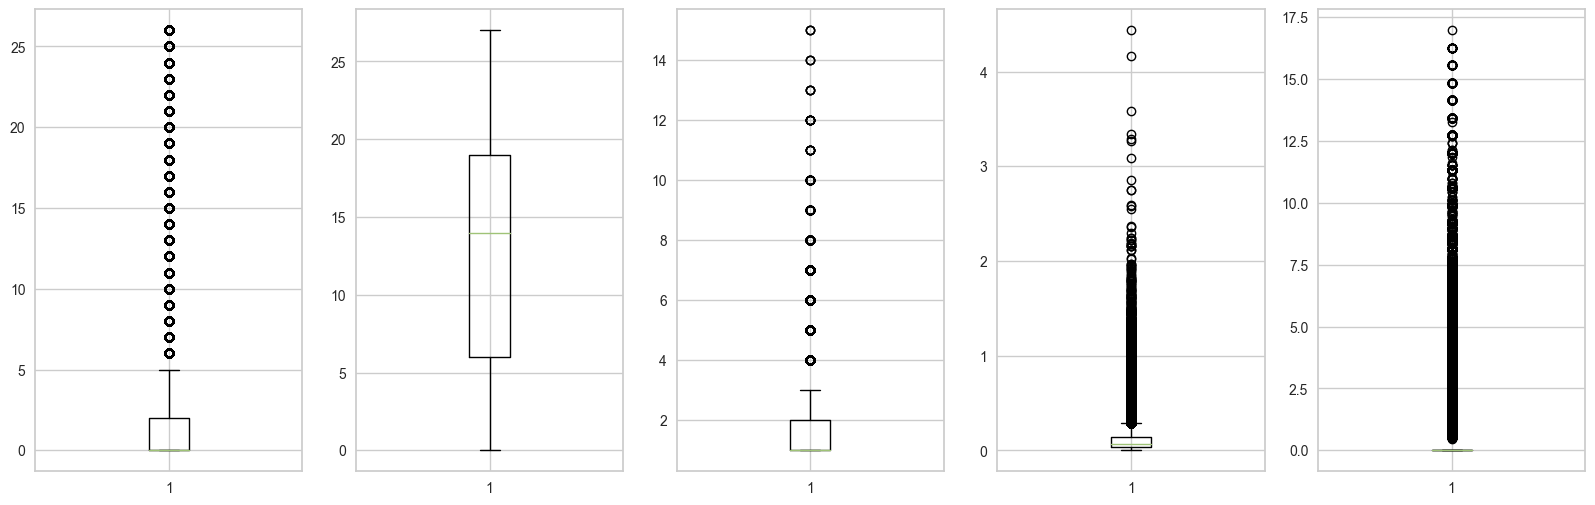

In [260]:
fig, ax = plt.subplots(1,5,figsize=(20,6))

feature_list = ['Length','Recency','Frequency','Monetary','Periodicity']

for i, j in enumerate(feature_list):
    ax[i].boxplot(lrfmp_data[j])

plt.show()

In [261]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
lrfmp_columns = ['Length','Recency','Frequency','Monetary','Periodicity']
lrfmp_data = pd.DataFrame(lrfmp_data,columns = lrfmp_columns
                          )
normalized_arr = preprocessing.normalize(lrfmp_data)
scaled_df = pd.DataFrame(normalized_arr, columns=lrfmp_columns)
print(scaled_df.describe())

lrfmp_ss_no_irq = scalar.fit_transform(scaled_df)
lrfmp_ss_no_irq = pd.DataFrame(scaled_df, columns = ['Length','Recency','Frequency','Monetary', 'Periodicity'])

              Length        Recency      Frequency       Monetary  \
count  235974.000000  235974.000000  235974.000000  235974.000000   
mean        0.172243       0.864828       0.143945       0.012143   
std         0.322659       0.263659       0.147940       0.023483   
min         0.000000       0.000000       0.036985       0.000031   
25%         0.000000       0.894411       0.055470       0.002578   
50%         0.000000       0.994744       0.099482       0.005613   
75%         0.139947       0.998458       0.164380       0.012429   
max         0.997053       0.999315       0.999999       0.811898   

         Periodicity  
count  235974.000000  
mean        0.017981  
std         0.071776  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         0.543757  


we wrill use standard scaler with outliers removed using IQR

## 6 Clustering algorithms

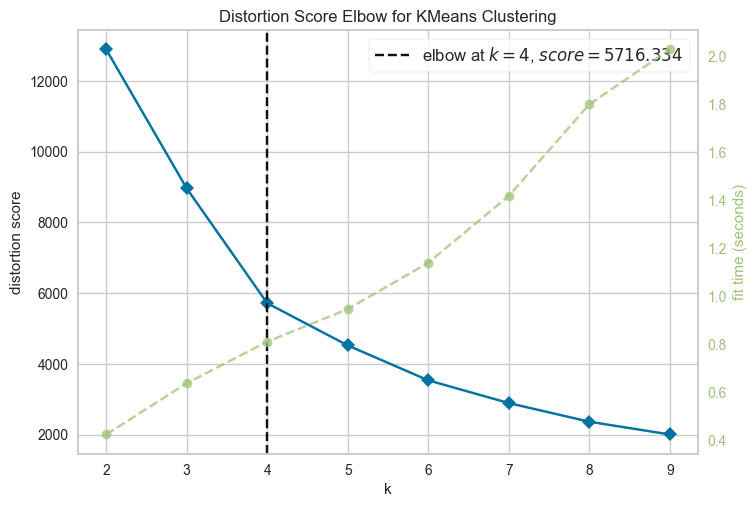

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [262]:

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(lrfmp_ss_no_irq)        # Fit data to visualizer
visualizer.show()



In [263]:
#Implementing K means with 3 clusters for LRFMP model

print('KMeans with 4 Clusters')
labels_kmean_4_lrfmp = KMeans(n_clusters = 4, init ='k-means++' ,n_init = 10, random_state=42, max_iter=300, tol=0.0001).fit_predict(lrfmp_ss_no_irq)
print(f'Davies Bouldin Index: {round(davies_bouldin_score(lrfmp_ss_no_irq, labels_kmean_4_lrfmp), 3)}')

KMeans with 4 Clusters
Davies Bouldin Index: 0.643


In [264]:
print(f'Silhouette Score: {round(silhouette_score(lrfmp_ss_no_irq, labels_kmean_4_lrfmp), 3)}')

Silhouette Score: 0.729


In [265]:
import matplotlib.pyplot as plt

from sklearn.cluster import Birch

In [266]:
model = Birch(branching_factor = 50, n_clusters = 4, threshold = 0.18)
model.fit(lrfmp_ss_no_irq)

Birch(n_clusters=4, threshold=0.18)

In [267]:
pred = model.predict(lrfmp_ss_no_irq)
birch_labels = model.labels_

In [268]:
print(f'Silhouette Score: {round(silhouette_score(lrfmp_ss_no_irq, birch_labels), 3)}')

Silhouette Score: 0.679


In [269]:

print(f'Davies Bouldin Index: {round(davies_bouldin_score(lrfmp_ss_no_irq, birch_labels), 3)}')

Davies Bouldin Index: 0.557


<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

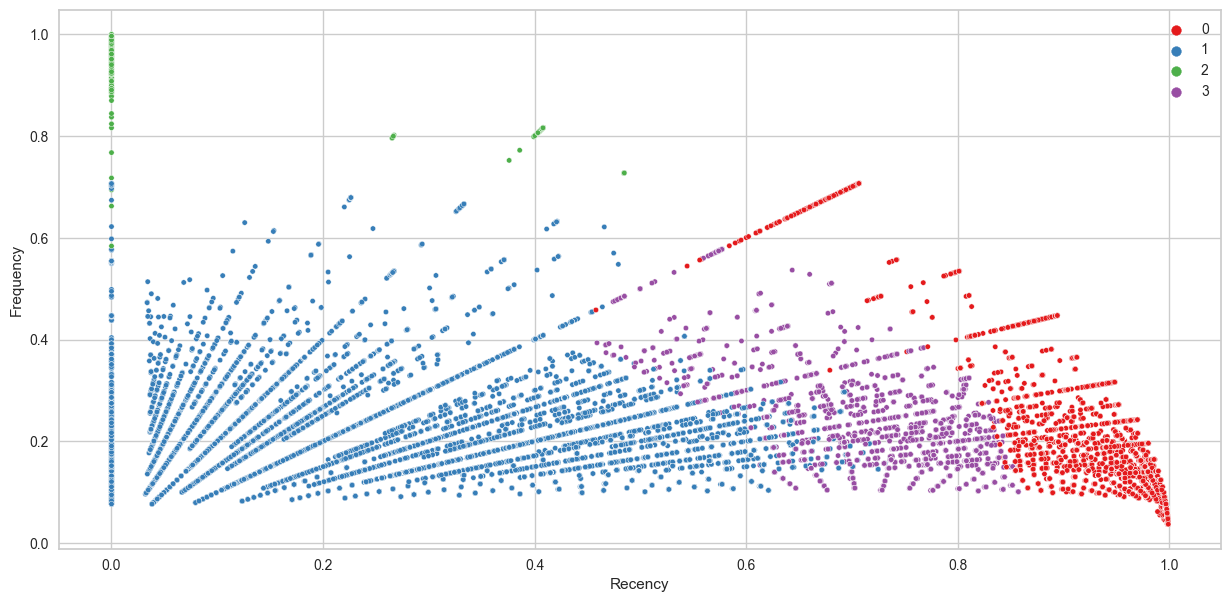

In [270]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=lrfmp_ss_no_irq, x='Recency', y='Frequency', hue = birch_labels, s=15, palette="Set1")

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

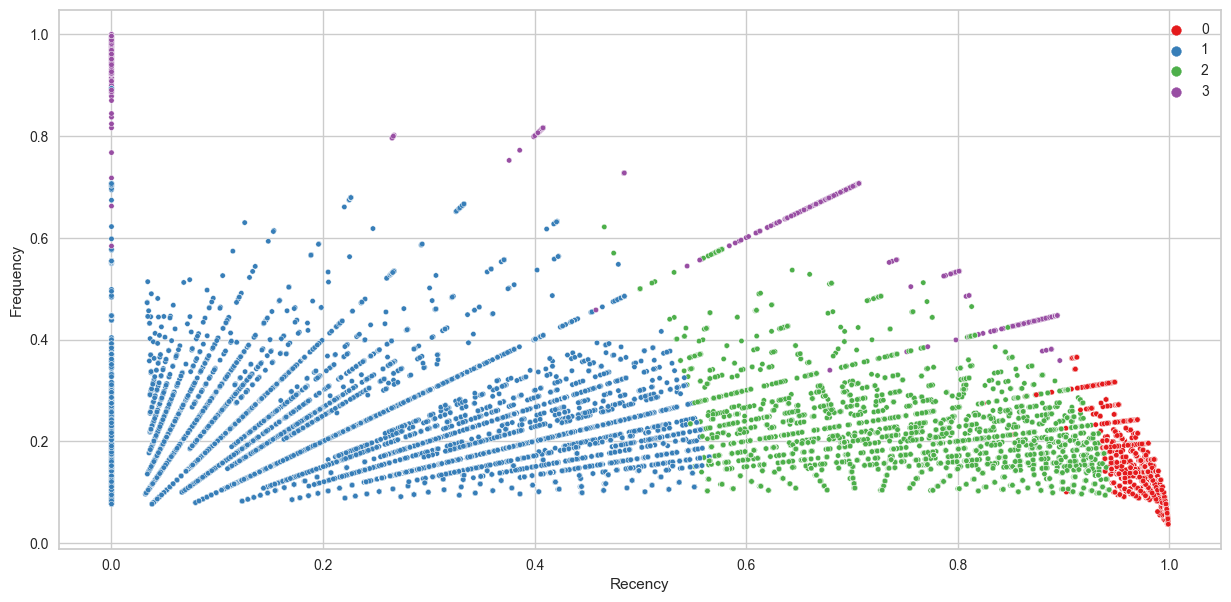

In [271]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=lrfmp_ss_no_irq, x='Recency', y='Frequency', hue = labels_kmean_4_lrfmp, s=15, palette="Set1")

In [275]:
# Taking into account the standard deviation of the normalised variables, monetary and periodicity has very less variation. hence removing those variables from the model to form LRF model

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
from sklearn import preprocessing
lrf_columns = ['Length','Recency','Frequency']
lrf_data =pd.DataFrame(lrf_data,columns=lrf_columns)
normalized_arr = preprocessing.normalize(lrf_data)
scaled_df = pd.DataFrame(normalized_arr, columns=lrf_data.columns)
print(scaled_df.describe())

lrf_ss_no_irq = scalar.fit_transform(scaled_df)
lrf_ss_no_irq = pd.DataFrame(scaled_df, columns = ['Length','Recency','Frequency'])

              Length        Recency      Frequency
count  235974.000000  235974.000000  235974.000000
mean        0.174825       0.865893       0.144708
std         0.328212       0.262359       0.148898
min         0.000000       0.000000       0.037012
25%         0.000000       0.894427       0.055470
50%         0.000000       0.995037       0.099504
75%         0.140028       0.998460       0.164399
max         0.997054       0.999315       1.000000


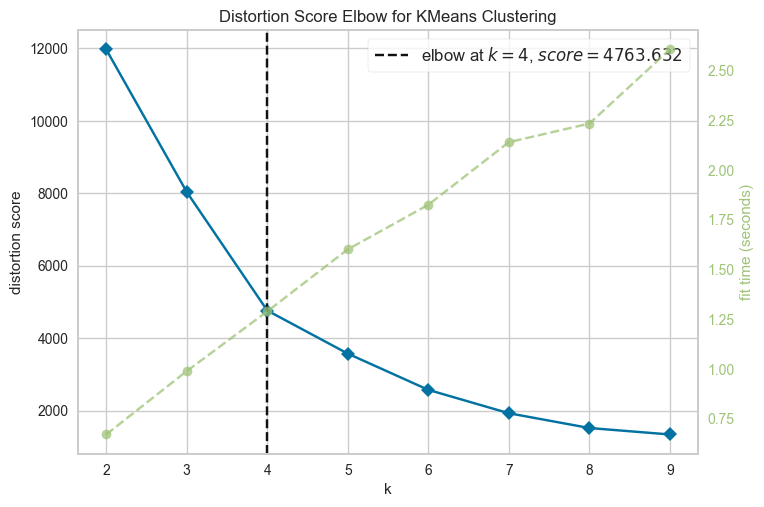

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [276]:
# We use Elbow method to calculate the optimal number of clusters. 
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(lrf_ss_no_irq)        # Fit data to visualizer
visualizer.show()

In [277]:
#Implementing K means with 3 clusters for LRF model

print('KMeans with 4 Clusters')
labels_kmean_4_lrf = KMeans(n_clusters = 4, init ='k-means++' ,n_init = 10, random_state=42, max_iter=300, tol=0.0001).fit_predict(lrf_ss_no_irq)
print(f'Davies Bouldin Index: {round(davies_bouldin_score(lrf_ss_no_irq, labels_kmean_4_lrf), 3)}')

KMeans with 4 Clusters
Davies Bouldin Index: 0.587


In [290]:
print(f'Silhouette Score: {round(silhouette_score(lrf_ss_no_irq, labels_kmean_4_lrf), 3)}')

Silhouette Score: 0.749


In [278]:
model = Birch(branching_factor = 50, n_clusters = 4, threshold = 0.06)
model.fit(lrf_ss_no_irq)

Birch(n_clusters=4, threshold=0.06)

In [279]:
pred = model.predict(lrf_ss_no_irq)
birch_labels = model.labels_

In [292]:
print(f'Silhouette Score: {round(silhouette_score(lrf_ss_no_irq, birch_labels), 3)}')


Silhouette Score: 0.565


In [293]:
print(f'Davies Bouldin Index: {round(davies_bouldin_score(lrf_ss_no_irq, birch_labels), 3)}')

Davies Bouldin Index: 1.673


In [295]:
# Next variable with less variation Length. Hence we are removing it.

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
from sklearn import preprocessing
lr_columns = ['Length','Recency']
lr_data = pd.DataFrame(lr_data,columns = lr_columns)
normalized_arr = preprocessing.normalize(lr_data)
scaled_df = pd.DataFrame(normalized_arr, columns=lr_data.columns)
print(scaled_df.describe())

lr_ss_no_irq = scalar.fit_transform(scaled_df)
lr_ss_no_irq = pd.DataFrame(scaled_df, columns = ['Length','Recency'])

              Length        Recency
count  235974.000000  235974.000000
mean        0.179125       0.883330
std         0.336017       0.262441
min         0.000000       0.000000
25%         0.000000       0.986394
50%         0.000000       1.000000
75%         0.141421       1.000000
max         1.000000       1.000000


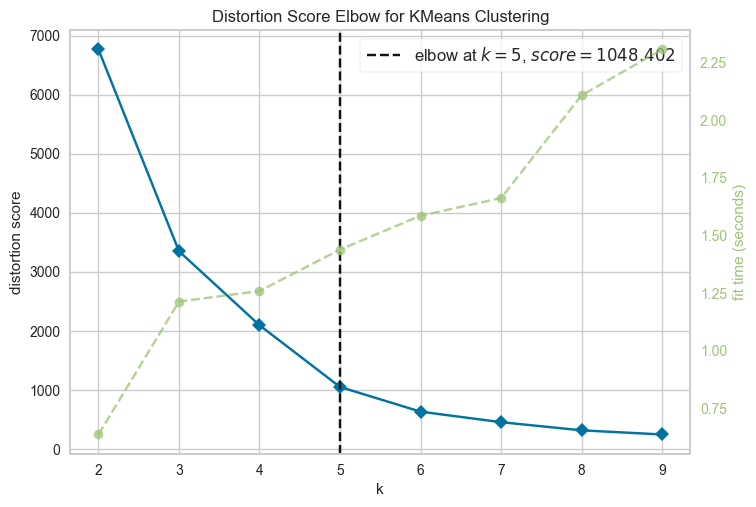

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [296]:
# We use Elbow method to calculate the optimal number of clusters. 
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(lr_ss_no_irq)        # Fit data to visualizer
visualizer.show()

In [297]:
#Implementing K means with 5 clusters for LR model

print('KMeans with 5 Clusters')
labels_kmean_5_lr= KMeans(n_clusters = 5, init ='k-means++' ,n_init = 10, random_state=42, max_iter=300, tol=0.0001).fit_predict(lr_ss_no_irq)
print(f'Davies Bouldin Index: {round(davies_bouldin_score(lr_ss_no_irq, labels_kmean_5_lr), 3)}')

KMeans with 5 Clusters
Davies Bouldin Index: 0.372


In [298]:
print(f'Silhouette Score: {round(silhouette_score(lr_ss_no_irq, labels_kmean_5_lr), 3)}')

Silhouette Score: 0.871


In [283]:
model = Birch(branching_factor = 50, n_clusters = 4, threshold = 0.06)
model.fit(lr_ss_no_irq)

Birch(n_clusters=4, threshold=0.06)

In [284]:
pred = model.predict(lr_ss_no_irq)
birch_labels = model.labels_

In [300]:
print(f'Silhouette Score: {round(silhouette_score(lr_ss_no_irq, birch_labels), 3)}')


Silhouette Score: 0.542


In [301]:
print(f'Davies Bouldin Index: {round(davies_bouldin_score(lr_ss_no_irq, birch_labels), 3)}')

Davies Bouldin Index: 1.513


In [302]:
# Next variable with less variation Length. Hence we are removing it.

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
from sklearn import preprocessing
rfm_columns = ['Recency','Frequency','Monetary']
rfm_data = pd.DataFrame(rfm_data,columns = rfm_columns)
normalized_arr = preprocessing.normalize(rfm_data)
scaled_df = pd.DataFrame(normalized_arr, columns=rfm_data.columns)
print(scaled_df.describe())

rfm_ss_no_irq = scalar.fit_transform(scaled_df)
rfm_ss_no_irq = pd.DataFrame(scaled_df, columns = ['Recency','Frequency','Monetary'])

             Recency      Frequency       Monetary
count  235974.000000  235974.000000  235974.000000
mean        0.937716       0.202735       0.016772
std         0.157417       0.231468       0.030794
min         0.000000       0.036985       0.000031
25%         0.969938       0.055470       0.002640
50%         0.995015       0.099503       0.006305
75%         0.998458       0.242523       0.017140
max         0.999315       0.999999       0.811898


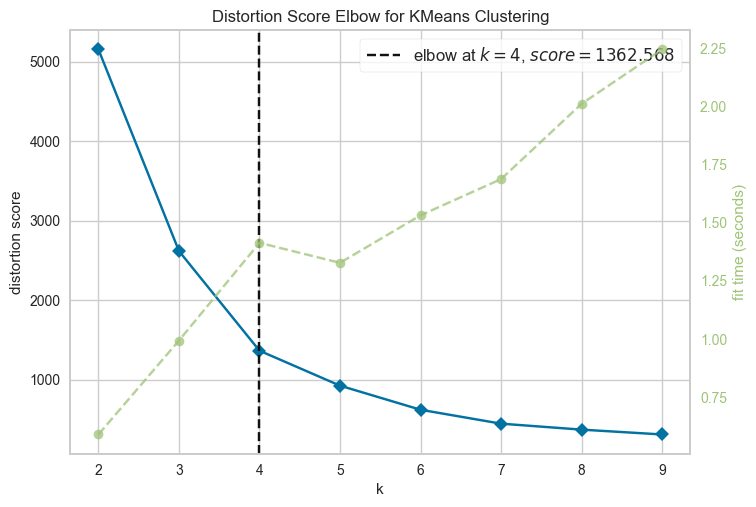

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [303]:
# We use Elbow method to calculate the optimal number of clusters. 
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(rfm_ss_no_irq)        # Fit data to visualizer
visualizer.show()

In [304]:
#Implementing K means with 4 clusters for RFM model

print('KMeans with 4 Clusters')
labels_kmean_4_rfm = KMeans(n_clusters = 4, init ='k-means++' ,n_init = 10, random_state=42, max_iter=300, tol=0.0001).fit_predict(rfm_ss_no_irq)
print(f'Davies Bouldin Index: {round(davies_bouldin_score(rfm_ss_no_irq, labels_kmean_4_rfm), 3)}')

KMeans with 4 Clusters
Davies Bouldin Index: 0.515


In [305]:
print(f'Silhouette Score: {round(silhouette_score(rfm_ss_no_irq, labels_kmean_4_rfm), 3)}')

Silhouette Score: 0.714


In [288]:
model = Birch(branching_factor = 50, n_clusters = 4, threshold = 0.176)
model.fit(rfm_ss_no_irq)

Birch(n_clusters=4, threshold=0.176)

In [289]:
pred = model.predict(rfm_ss_no_irq)
birch_labels = model.labels_

In [306]:
print(f'Silhouette Score: {round(silhouette_score(rfm_ss_no_irq, birch_labels), 3)}')


Silhouette Score: 0.749


In [307]:
print(f'Davies Bouldin Index: {round(davies_bouldin_score(rfm_ss_no_irq, birch_labels), 3)}')

Davies Bouldin Index: 0.483
